In [ ]:
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 5.24 ms (started: 2024-12-15 01:02:52 +00:00)


In [ ]:
!pip install pulp

time: 6.64 s (started: 2024-12-15 01:02:52 +00:00)


Code Written By: Patrick Rei Audije

Develop Linear Programming code to solve for Uncapacitated Facility Location Problem. Two versions of Linear Programming implementation is performed, Optimal to perform exact values and Relaxation for approximate values.

The following terms are used to define the constraints of UFLP:


*   C is the Set of Customers with m as the length of the set and j being customer number
*   F is the Set of Facilities with n as length of the set and i being customer number
*   d represents Customer demand costs, depends on j
*   f represents each facility's opening costs, depends on i
*   c represents costs for each facility to serve each customer (i, j)
*   z represents if customer "j" is served by facility "i" (1 = yes, 0 = no)
*   x represents if facility "i" is open (1 = yes, 0 = no)

These are all represented and utilized in the following Linear Program for UFLP:

$$
\mathsf{minimum} \sum_{i=1}^n \sum_{j=1}^m c_{ij}d_{j}z_{ij} + \sum_{i=1}^n f_i x_i \\
\mathsf{s.t.} \sum_{i=1}^n z_{ij} \text{ for all }\ j=1, \ldots, m \\
z_{ij}\leq x_i \text{ for all } i=1, \ldots, n \text{ and } j=1, \ldots, m \\
z_{ij} \text{ in binary set {0,1} for all } i=1, \ldots, n \text{ and } j=1, \ldots, m \\
x_i \text{ in binary set {0,1} for all } i=1, \ldots, n
$$

In [ ]:
from pulp import *
import time
import random
import matplotlib.pyplot as plt

def compute_optimal_uflp(n, m, facilities, demands, transport_costs, f_locations, c_locations):
    start = time.time()
    # Create a problem -- indicate that we will minimize the objectives
    prob = LpProblem('UFLP', LpMinimize)

    # Add all the decision vars (we do this using comprehensions in Python but you could write a for-loop as well)
    decision_x = [LpVariable(f'x_{i}', cat='Binary') for i in range(n)]
    decision_z = [[LpVariable(f'z_{i}_{j}', cat='Binary') for j in range(m)] for i in range(n)]

    # minimum/objective function
    prob += lpSum(facilities[i] * decision_x[i] for i in range(n)) + lpSum(transport_costs[i][j] * demands[j] * decision_z[i][j] for i in range(n) for j in range(m))# minimize the sum of the variables

    # Constraint: Customer must be assigned to one facility
    for j in range(m):
        prob += lpSum(decision_z[i][j] for i in range(n)) == 1, f'Customer_{j}'

    # Constraint: Customer can only be assigned to open facility
    for i in range(n):
        for j in range(m):
            prob += decision_z[i][j] <= decision_x[i], f'Facility_{i}_Customer_{j}'

    # Solve the problem
    stat = prob.solve()
    assert stat == LpStatusOptimal, 'Problem does not have optimal status -- something went wrong -- this should not happen for this problem'

    # Print Results
    print("Problem Status: ", LpStatus[prob.status])
    print("Optimal Cost: ",value(prob.objective))
    open = [i for i in range(n) if decision_x[i].varValue >= 0.5]
    print("Open Facilities: ", open)
    for j in range(m):
      assigned = [i for i in range(n) if decision_z[i][j].varValue >= 0.5]
      print(f"Customer {j} is assigned to facility {assigned}")

    # Print Time
    end = time.time()
    total = end - start
    print("Exact Time (s): ", total)

    # Plot Graph
    plot_uflp(n, m, decision_z, f_locations, c_locations)

    return prob.solve()

def compute_relaxation_uflp(n, m, facilities, demands, transport_costs, f_locations, c_locations):
    start = time.time()
    # Create a problem -- indicate that we will minimize the objectives
    prob = LpProblem('UFLP', LpMinimize)

    # Add all the decision vars (we do this using comprehensions in Python but you could write a for-loop as well)
    decision_x = [LpVariable(f'x_{i}', lowBound=0, upBound=1, cat='Continuous') for i in range(n)]
    decision_z = [[LpVariable(f'z_{i}_{j}', lowBound=0, upBound=1, cat='Continuous') for j in range(m)] for i in range(n)]

    # minimum/objective function
    prob += lpSum(facilities[i] * decision_x[i] for i in range(n)) + lpSum(transport_costs[i][j] * demands[j] * decision_z[i][j] for i in range(n) for j in range(m))# minimize the sum of the variables

    # Constraint: Customer must be assigned to one facility
    for j in range(m):
        prob += lpSum(decision_z[i][j] for i in range(n)) == 1, f'Customer_{j}'

    # Constraint: Customer can only be assigned to open facility
    for i in range(n):
        for j in range(m):
            prob += decision_z[i][j] <= decision_x[i], f'Facility_{i}_Customer_{j}'

    # Solve the problem
    stat = prob.solve()
    assert stat == LpStatusOptimal, 'Problem does not have optimal status -- something went wrong -- this should not happen for this problem'

    # Print Results
    print("Problem Status: ", LpStatus[prob.status])
    print("Optimal Cost: ",value(prob.objective))
    open = [i for i in range(n) if decision_x[i].varValue > 0.5]
    print("Open Facilities: ", open)
    for j in range(m):
      assigned = [i for i in range(n) if decision_z[i][j].varValue >= 0.5]
      print(f"Customer {j} is assigned to facility {assigned}")

    # Print Time
    end = time.time()
    total = end - start
    print("Exact Time (s): ", total)

    # Plot Graph
    plot_uflp(n, m, decision_z, f_locations, c_locations)

    return prob.solve()

time: 3.07 ms (started: 2024-12-15 01:02:59 +00:00)


In [ ]:
def plot_uflp(n, m, decision_z, f_locations, c_locations):

  fig, ax = plt.subplots()

  for i in range(n):
    ax.scatter(*f_locations[i], color='green', label=f'Facility {i}' )

  for j in range(m):
    ax.scatter(*c_locations[j], color='red', label=f'Customer {i}')

  for j in range(m):
    assigned = [i for i in range(n) if decision_z[i][j].varValue >= 0.5]
    if assigned:
      f_index = assigned[0]
      ax.plot([f_locations[f_index][0], c_locations[j][0]], [f_locations[f_index][1], c_locations[j][1]], 'k-')
  ax.set_xlabel('X-axis')
  ax.set_ylabel('Y-axis')
  ax.set_title('Uncapacitated Facility Location Problem')
  plt.show()


time: 908 µs (started: 2024-12-15 01:02:59 +00:00)


Problem 1: Small Example

Optimal UFLP
Problem Status:  Optimal
Optimal Cost:  56.0
Open Facilities:  [0, 1]
Customer 0 is assigned to facility [0]
Customer 1 is assigned to facility [1]
Customer 2 is assigned to facility [0]
Exact Time (s):  0.01767706871032715


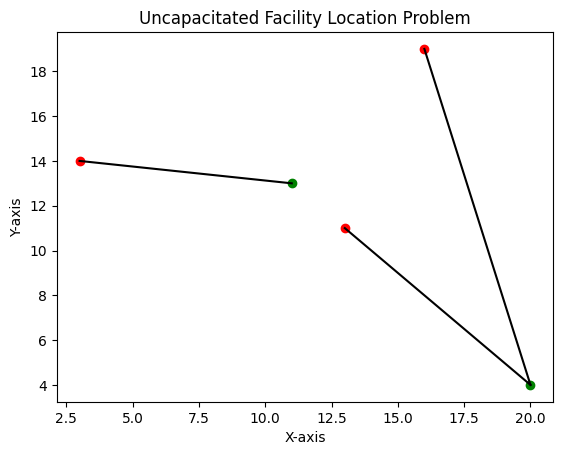



Relaxation UFLP
Problem Status:  Optimal
Optimal Cost:  56.0
Open Facilities:  [0, 1]
Customer 0 is assigned to facility [0]
Customer 1 is assigned to facility [1]
Customer 2 is assigned to facility [0]
Exact Time (s):  0.011066198348999023


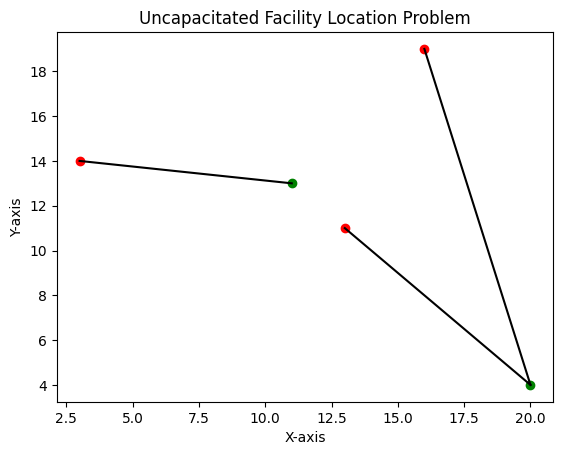



time: 862 ms (started: 2024-12-15 01:02:59 +00:00)


In [ ]:
F = 2
C = 3
f = [8, 10]
d = [3, 4, 2]
c = [[4, 8, 3],[6, 5, 5]]
f_locations = [(random.randint(0, 20), random.randint(0,20)) for _ in range(F)]
c_locations = [(random.randint(0, 20), random.randint(0,20)) for _ in range(C)]

print("Optimal UFLP")
opt_result = compute_optimal_uflp(F, C, f, d, c, f_locations, c_locations)
print("\n")

print("Relaxation UFLP")
relax_result = compute_relaxation_uflp(F, C, f, d, c, f_locations, c_locations)
print("\n")

Problem 2: "Medium-Sized" Example

Optimal UFLP
Problem Status:  Optimal
Optimal Cost:  32896.0
Open Facilities:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Customer 0 is assigned to facility [4]
Customer 1 is assigned to facility [7]
Customer 2 is assigned to facility [3]
Customer 3 is assigned to facility [5]
Customer 4 is assigned to facility [3]
Customer 5 is assigned to facility [6]
Customer 6 is assigned to facility [8]
Customer 7 is assigned to facility [7]
Customer 8 is assigned to facility [0]
Customer 9 is assigned to facility [8]
Customer 10 is assigned to facility [6]
Customer 11 is assigned to facility [9]
Customer 12 is assigned to facility [4]
Customer 13 is assigned to facility [4]
Customer 14 is assigned to facility [2]
Customer 15 is assigned to facility [1]
Customer 16 is assigned to facility [5]
Customer 17 is assigned to facility [2]
Customer 18 is assigned to facility [8]
Customer 19 is assigned to facility [4]
Customer 20 is assigned to facility [6]
Customer 21 is assigned to facility [9]
Customer 22 is assig

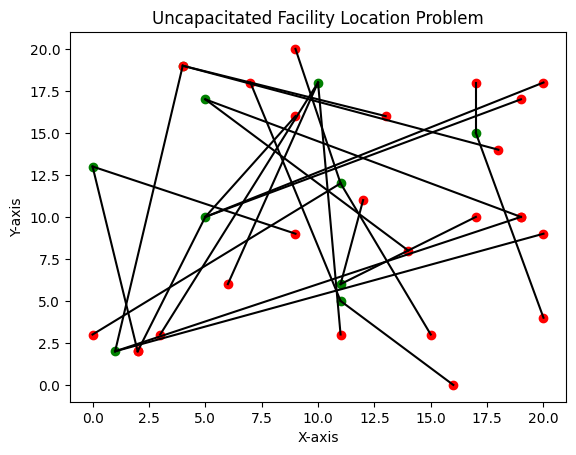



Relaxation UFLP
Problem Status:  Optimal
Optimal Cost:  32896.0
Open Facilities:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Customer 0 is assigned to facility [4]
Customer 1 is assigned to facility [7]
Customer 2 is assigned to facility [3]
Customer 3 is assigned to facility [5]
Customer 4 is assigned to facility [3]
Customer 5 is assigned to facility [6]
Customer 6 is assigned to facility [8]
Customer 7 is assigned to facility [7]
Customer 8 is assigned to facility [0]
Customer 9 is assigned to facility [8]
Customer 10 is assigned to facility [6]
Customer 11 is assigned to facility [9]
Customer 12 is assigned to facility [4]
Customer 13 is assigned to facility [4]
Customer 14 is assigned to facility [2]
Customer 15 is assigned to facility [1]
Customer 16 is assigned to facility [5]
Customer 17 is assigned to facility [2]
Customer 18 is assigned to facility [8]
Customer 19 is assigned to facility [4]
Customer 20 is assigned to facility [6]
Customer 21 is assigned to facility [9]
Customer 22 is 

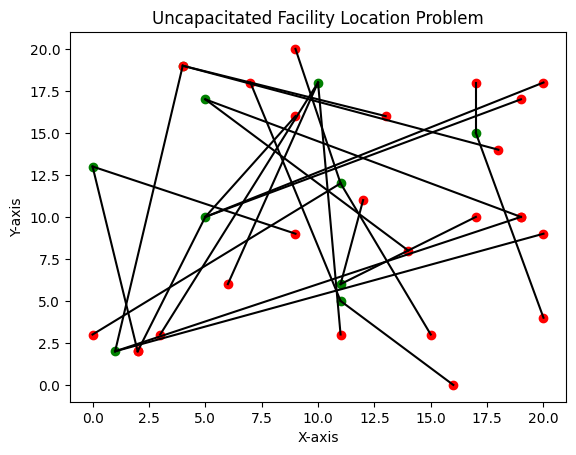



time: 1.37 s (started: 2024-12-15 01:34:00 +00:00)


In [ ]:
F = 10
C = 25
f = [random.randint(25, 75) for _ in range(F)]
d = [random.randint(25, 75) for _ in range(C)]
c = [[random.randint(25, 75) for _ in range(C)] for _ in range(F)]
f_locations = [(random.randint(0, 20), random.randint(0,20)) for _ in range(F)]
c_locations = [(random.randint(0, 20), random.randint(0,20)) for _ in range(C)]

print("Optimal UFLP")
opt_result = compute_optimal_uflp(F, C, f, d, c, f_locations, c_locations)
print("\n")

print("Relaxation UFLP")
relax_result = compute_relaxation_uflp(F, C, f, d, c, f_locations, c_locations)
print("\n")

Problem 3: Large Example


Optimal UFLP
Problem Status:  Optimal
Optimal Cost:  632199.9959041841
Open Facilities:  [0, 1, 3, 4, 5, 6, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 31, 32, 33, 36, 38, 39, 41, 42, 45, 46, 47, 48, 49]
Customer 0 is assigned to facility [18]
Customer 1 is assigned to facility [4]
Customer 2 is assigned to facility [25]
Customer 3 is assigned to facility [11]
Customer 4 is assigned to facility [21]
Customer 5 is assigned to facility [23]
Customer 6 is assigned to facility [25]
Customer 7 is assigned to facility [36]
Customer 8 is assigned to facility [36]
Customer 9 is assigned to facility [28]
Customer 10 is assigned to facility [25]
Customer 11 is assigned to facility [3]
Customer 12 is assigned to facility [8]
Customer 13 is assigned to facility [20]
Customer 14 is assigned to facility [47]
Customer 15 is assigned to facility [33]
Customer 16 is assigned to facility [21]
Customer 17 is assigned to facility [29]
Customer 18 is assigned to facility [21]
Cust

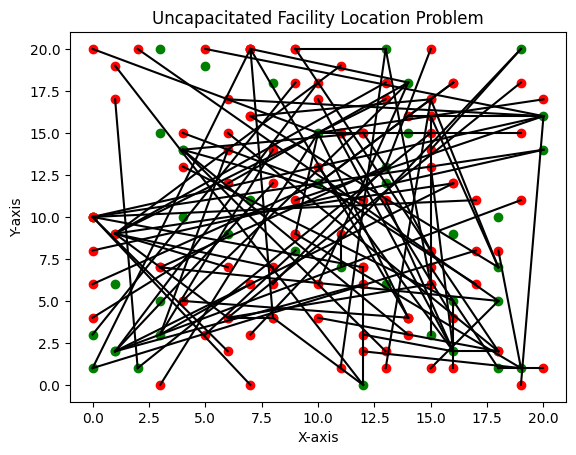



Relaxation UFLP
Problem Status:  Optimal
Optimal Cost:  632199.9959041841
Open Facilities:  [0, 1, 3, 4, 5, 6, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 31, 32, 33, 36, 38, 39, 41, 42, 45, 46, 47, 48, 49]
Customer 0 is assigned to facility [18]
Customer 1 is assigned to facility [4]
Customer 2 is assigned to facility [25]
Customer 3 is assigned to facility [11]
Customer 4 is assigned to facility [21]
Customer 5 is assigned to facility [23]
Customer 6 is assigned to facility [25]
Customer 7 is assigned to facility [36]
Customer 8 is assigned to facility [36]
Customer 9 is assigned to facility [28]
Customer 10 is assigned to facility [25]
Customer 11 is assigned to facility [3]
Customer 12 is assigned to facility [8]
Customer 13 is assigned to facility [20]
Customer 14 is assigned to facility [47]
Customer 15 is assigned to facility [33]
Customer 16 is assigned to facility [21]
Customer 17 is assigned to facility [29]
Customer 18 is assigned to facility [21]

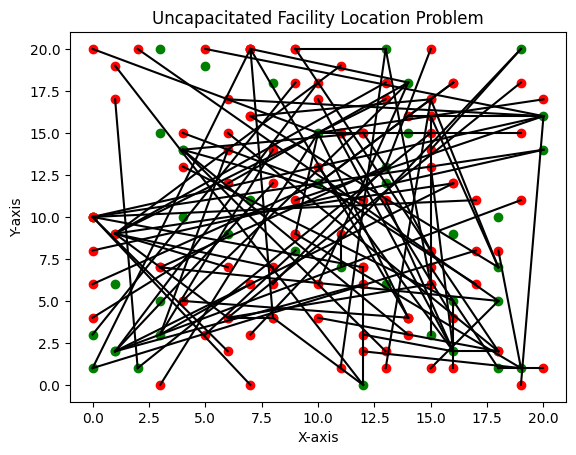



time: 6 s (started: 2024-12-15 02:07:10 +00:00)


In [ ]:
F = 50
C = 100
f = [random.uniform(50, 200) for _ in range(F)]
d = [random.uniform(50, 200) for _ in range(C)]
c = [[random.uniform(50, 200) for _ in range(C)] for _ in range(F)]
f_locations = [(random.randint(0, 20), random.randint(0,20)) for _ in range(F)]
c_locations = [(random.randint(0, 20), random.randint(0,20)) for _ in range(C)]

print("Optimal UFLP")
opt_result = compute_optimal_uflp(F, C, f, d, c, f_locations, c_locations)
print("\n")

print("Relaxation UFLP")
relax_result = compute_relaxation_uflp(F, C, f, d, c, f_locations, c_locations)
print("\n")